# Data Pre-processing 
This notebook performs data pre-processing of FoodSeg103 dataset.

## Output
Due to the large volume of data, the output pre-processed dataset has been compressed into a zip file and uploaded to the shared drive. Please download the zip file from the drive, unzip it and upload the file to your vscode locally. The directory.

## Folder Structure Explained\n",
**`images`**: Contains pre-processed images (`.jpg`) for YOLOv8 training.
**`labels`**: Contains YOLOv8 annotations (`.txt`) with class IDs, bounding boxes, and segmentation points.
**`sam`**: Contains raw images (`.jpg`) and masks (`.png`) for SAM training or inference.

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from glob import glob
import random
from PIL import Image
from datasets import load_dataset, Dataset
import albumentations as A
import shutil
from pathlib import Path

In [2]:
# Load dataset
ds = load_dataset("EduardoPacheco/FoodSeg103")
train_dataset = ds["train"]
val_dataset = ds["validation"]

In [3]:
def split_test_dataset(train_dataset, val_dataset, num_samples):
    if num_samples > len(train_dataset) or num_samples > len(val_dataset):
        raise ValueError("num_samples cannot exceed the number of entries in either dataset.")
    sampled_train_indices = random.sample(range(len(train_dataset)), num_samples)
    test_from_train = train_dataset.select(sampled_train_indices)
    remaining_train_indices = list(set(range(len(train_dataset))) - set(sampled_train_indices))
    updated_train_dataset = train_dataset.select(remaining_train_indices)
    sampled_val_indices = random.sample(range(len(val_dataset)), num_samples)
    test_from_val = val_dataset.select(sampled_val_indices)
    remaining_val_indices = list(set(range(len(val_dataset))) - set(sampled_val_indices))
    updated_val_dataset = val_dataset.select(remaining_val_indices)
    test_dataset = Dataset.from_dict({
        "image": test_from_train["image"] + test_from_val["image"],
        "label": test_from_train["label"] + test_from_val["label"],
        "classes_on_image": test_from_train["classes_on_image"] + test_from_val["classes_on_image"],
        "id": test_from_train["id"] + test_from_val["id"],
    })
    return updated_train_dataset, updated_val_dataset, test_dataset

In [4]:
num_samples = 100
train_dataset, val_dataset, test_dataset = split_test_dataset(train_dataset, val_dataset, num_samples)

In [5]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'classes_on_image', 'id'],
        num_rows: 4983
    })
    validation: Dataset({
        features: ['image', 'label', 'classes_on_image', 'id'],
        num_rows: 2135
    })
})


In [6]:
ingredients = np.array(
    [
        "background",
        "candy",
        "egg tart",
        "french fries",
        "chocolate",
        "biscuit",
        "popcorn",
        "pudding",
        "ice cream",
        "cheese butter",
        "cake",
        "wine",
        "milkshake",
        "coffee",
        "juice",
        "milk",
        "tea",
        "almond",
        "red beans",
        "cashew",
        "dried cranberries",
        "soy",
        "walnut",
        "peanut",
        "egg",
        "apple",
        "date",
        "apricot",
        "avocado",
        "banana",
        "strawberry",
        "cherry",
        "blueberry",
        "raspberry",
        "mango",
        "olives",
        "peach",
        "lemon",
        "pear",
        "fig",
        "pineapple",
        "grape",
        "kiwi",
        "melon",
        "orange",
        "watermelon",
        "steak",
        "pork",
        "chicken duck",
        "sausage",
        "fried meat",
        "lamb",
        "sauce",
        "crab",
        "fish",
        "shellfish",
        "shrimp",
        "soup",
        "bread",
        "corn",
        "hamburg",
        "pizza",
        "hanamaki baozi",
        "wonton dumplings",
        "pasta",
        "noodles",
        "rice",
        "pie",
        "tofu",
        "eggplant",
        "potato",
        "garlic",
        "cauliflower",
        "tomato",
        "kelp",
        "seaweed",
        "spring onion",
        "rape",
        "ginger",
        "okra",
        "lettuce",
        "pumpkin",
        "cucumber",
        "white radish",
        "carrot",
        "asparagus",
        "bamboo shoots",
        "broccoli",
        "celery stick",
        "cilantro mint",
        "snow peas",
        "cabbage",
        "bean sprouts",
        "onion",
        "pepper",
        "green beans",
        "French beans",
        "king oyster mushroom",
        "shiitake",
        "enoki mushroom",
        "oyster mushroom",
        "white button mushroom",
        "salad",
        "other ingredients",
    ]
)

Shape of training dataset: (4883, 4) 
Shape of validation dataset: (2035, 4)
Shape of test dataset: (200, 4)


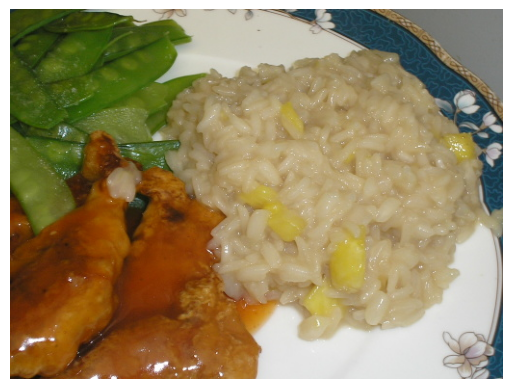

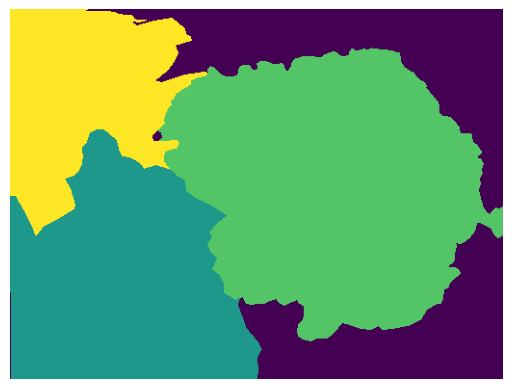

background
chicken duck
rice
snow peas


In [7]:
# Print sample items from dataset
print(
    f"Shape of training dataset: {train_dataset.shape} \nShape of validation dataset: {val_dataset.shape}\nShape of test dataset: {test_dataset.shape}"
)
# print(train_dataset[0]["id"])
# print(train_dataset[0]["image"])
# Display the image
image = train_dataset[0]["image"]
plt.imshow(image)
plt.axis("off")  # Turn off axis labels
plt.show()

# Display the label
label = train_dataset[0]["label"]
plt.imshow(label)
plt.axis("off")  # Turn off axis labels
plt.show()

# Print ingredient name according to the label
for index in train_dataset[0]["classes_on_image"]:
    if index < len(ingredients):
        print(ingredients[index])

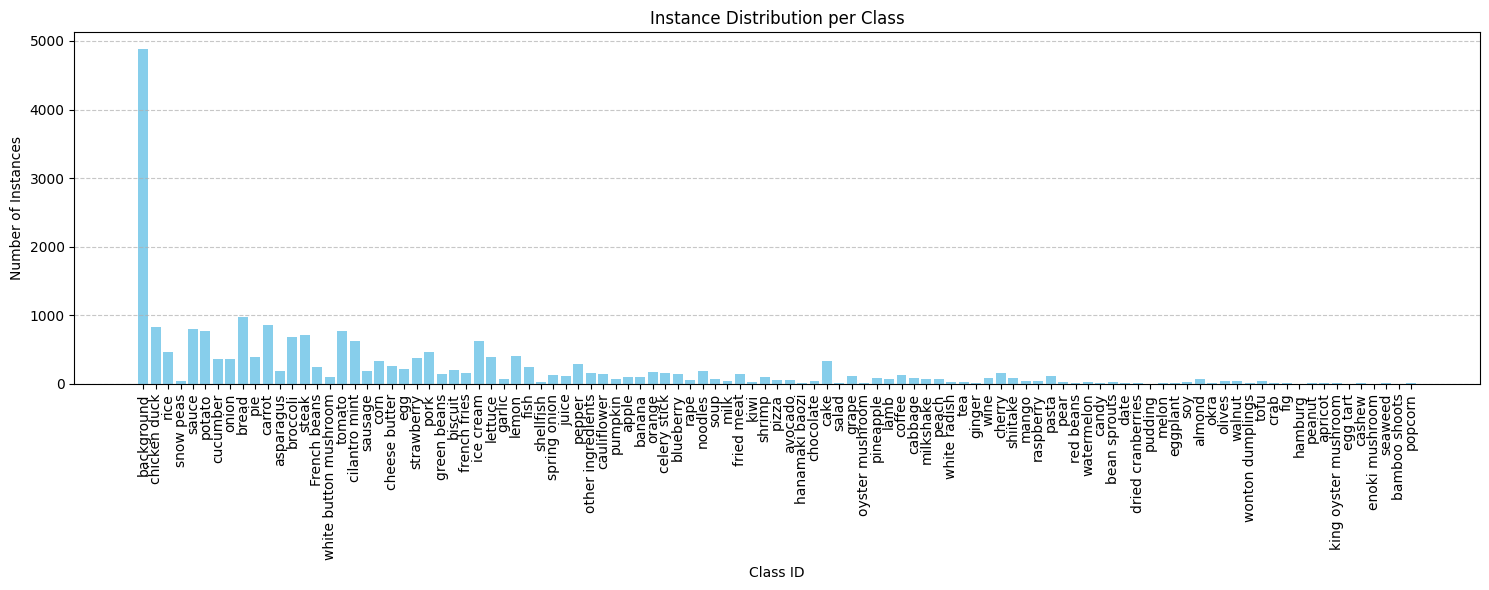

Class Distribution Summary:
           Class ID  Count
0        background   4882
1      chicken duck    830
2              rice    459
3         snow peas     48
4             sauce    802
..              ...    ...
98           cashew     12
99   enoki mushroom      6
100         seaweed      7
101   bamboo shoots      2
102         popcorn      9

[103 rows x 2 columns]


In [8]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Check if the labels directory exists
if not ds:
    print("Database is not loaded!")
else:
    # Counter for class occurrences
    class_counter = Counter()

    # Iterate over each train item to add to counter
    for item in train_dataset:
        for class_id in item["classes_on_image"]:
            class_counter[ingredients[class_id]] += 1
    # Plotting the distribution
    classes, counts = zip(*(class_counter.items()))

    plt.figure(figsize=(15, 6))
    plt.bar(classes, counts, color="skyblue")
    plt.xlabel("Class ID")
    plt.ylabel("Number of Instances")
    plt.title("Instance Distribution per Class")
    plt.xticks(rotation=90)

    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()

class_summary = [
    {"Class ID": class_id, "Count": count} for class_id, count in class_counter.items()
]
class_summary_df = pd.DataFrame(class_summary)
print("Class Distribution Summary:")
print(class_summary_df)

In [9]:
def augment_and_preprocess_image(image, mask=None):
    """Apply augmentation and preprocessing (resize, normalize) to images and masks."""
    augmentation = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.2, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.5),
        A.Resize(height=640, width=640),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ], p=1.0, additional_targets={'mask': 'mask'})
    if mask is not None:
        augmented = augmentation(image=image, mask=mask)
        return augmented["image"], augmented["mask"]
    return augmentation(image=image)["image"]

In [10]:
def preprocess_image_basic(image, mask=None):
    """Basic preprocessing (resize only) for visualization."""
    interpolation = cv2.INTER_NEAREST if mask is not None else cv2.INTER_LINEAR
    transform = A.Compose([
        A.Resize(height=640, width=640, interpolation=interpolation),
    ], additional_targets={'mask': 'mask'})
    if mask is not None:
        result = transform(image=image, mask=mask)
        return result["image"], result["mask"]
    return transform(image=image)["image"]

In [11]:
def show_preprocessing_and_augmentation(ds):
    """Display original, preprocessed (resized), and augmented image-mask pairs."""
    sample = random.choice(ds)
    image = np.array(sample["image"])
    mask = np.array(sample["label"])

    # Basic preprocessing (resize only)
    preproc_image, preproc_mask = preprocess_image_basic(image, mask)
    # Augmented and preprocessed
    aug_image, aug_mask = augment_and_preprocess_image(image, mask)

    plt.figure(figsize=(20, 15))
    plt.subplot(3, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis("off")
    plt.subplot(3, 2, 2)
    plt.title("Original Mask")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    plt.subplot(3, 2, 3)
    plt.title("Preprocessed Image (Resized)")
    plt.imshow(preproc_image)
    plt.axis("off")
    plt.subplot(3, 2, 4)
    plt.title("Preprocessed Mask (Resized)")
    plt.imshow(preproc_mask, cmap="gray")
    plt.axis("off")
    plt.subplot(3, 2, 5)
    plt.title("Augmented & Normalized Image")
    plt.imshow(aug_image * 255)  # Denormalize for display
    plt.axis("off")
    plt.subplot(3, 2, 6)
    plt.title("Augmented Mask")
    plt.imshow(aug_mask, cmap="gray")
    plt.axis("off")
    plt.show()

c:\Users\Gigi Wan\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-540.0655..664.3111].


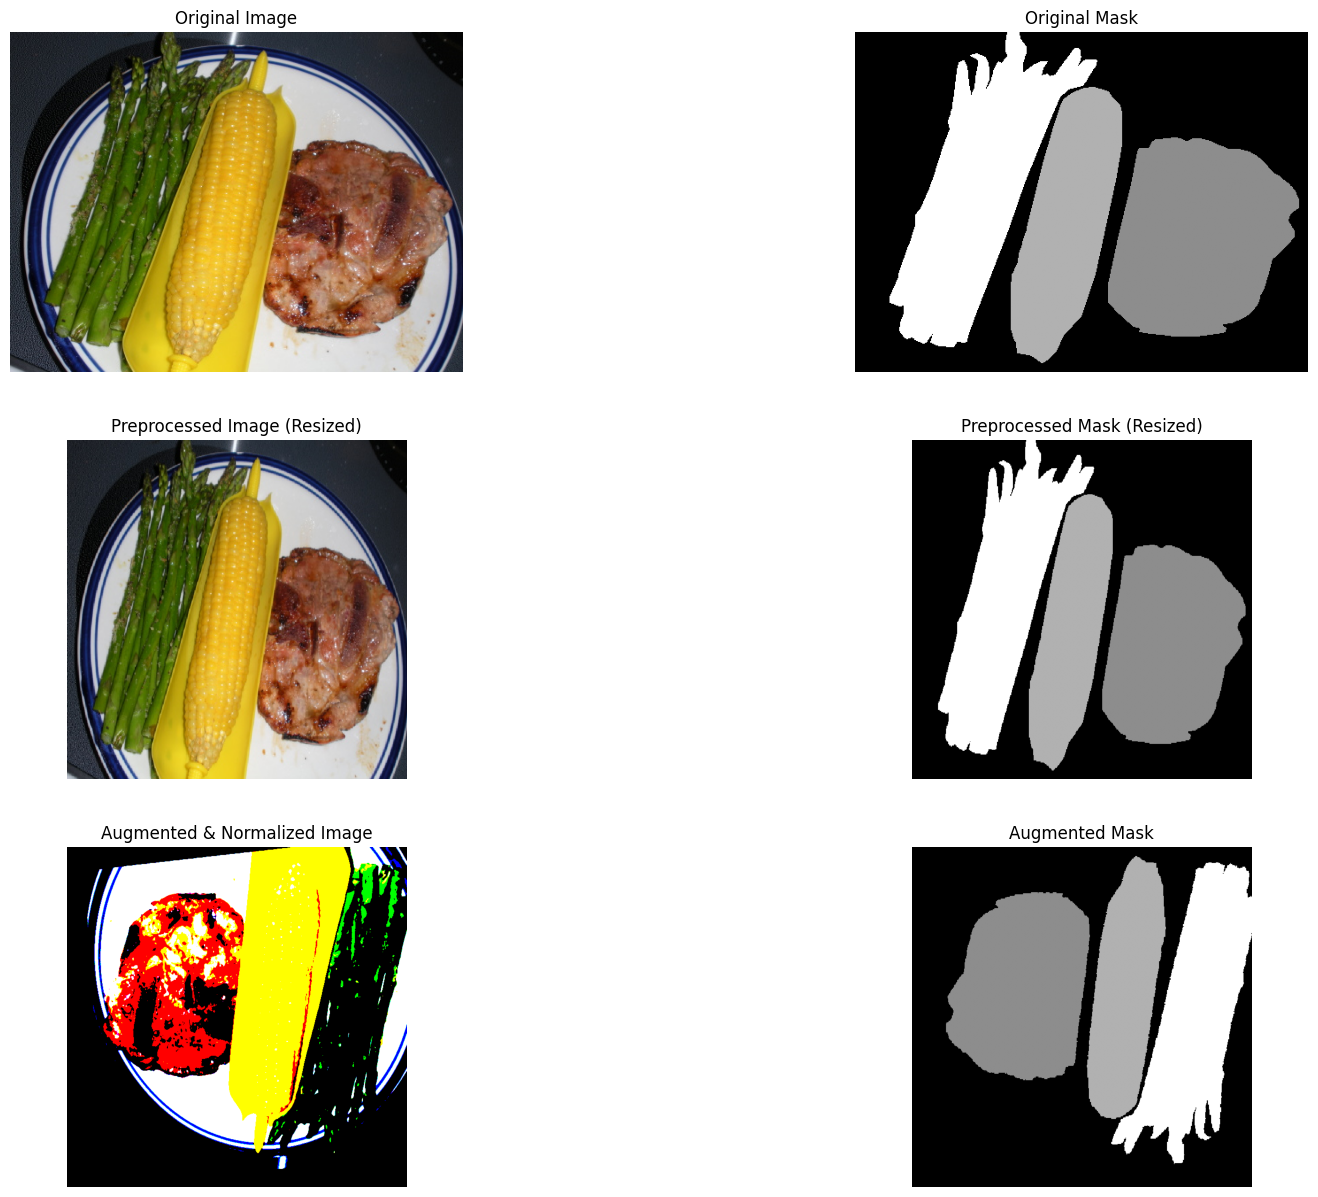

In [12]:
show_preprocessing_and_augmentation(train_dataset)

In [14]:
def preprocess_and_save_dataset(dataset, split_name, base_dir="data/foodseg103", augmentations=True):
    split_dir = Path(base_dir) / split_name
    yolo_images_dir = split_dir / "images"  # Only images (.jpg) for YOLOv8
    yolo_labels_dir = split_dir / "labels"  # Annotations (.txt) for YOLOv8
    sam_dir = split_dir / "sam"             # Images (.jpg) and masks (.png) for SAM
    
    # Create directories
    for d in [yolo_images_dir, yolo_labels_dir, sam_dir]:
        d.mkdir(parents=True, exist_ok=True)
    
    for i, entry in enumerate(dataset):
        image = np.array(entry["image"])
        mask = np.array(entry["label"])
        
        # Save original image for YOLOv8
        orig_image_path = yolo_images_dir / f"{entry['id']}.jpg"
        cv2.imwrite(str(orig_image_path), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        
        # YOLOv8 annotations
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        with open(yolo_labels_dir / f"{entry['id']}.txt", "w") as f:
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                class_id = entry["classes_on_image"][0] if entry["classes_on_image"] else 0
                xc, yc, wn, hn = (x + w/2) / 640, (y + h/2) / 640, w / 640, h / 640
                points = contour.reshape(-1, 2) / 640
                points_str = " ".join(f"{p[0]:.6f} {p[1]:.6f}" for p in points)
                f.write(f"{class_id} {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f} {points_str}\n")
        
        # SAM: Save raw image and mask
        cv2.imwrite(str(sam_dir / f"{entry['id']}_image.jpg"), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        cv2.imwrite(str(sam_dir / f"{entry['id']}_mask.png"), mask)
        
        # Augmentation (for training only)
        if augmentations:
            aug_image, aug_mask = augment_and_preprocess_image(image, mask)
            aug_id = f"{entry['id']}_aug"
            cv2.imwrite(str(yolo_images_dir / f"{aug_id}.jpg"), cv2.cvtColor(aug_image * 255, cv2.COLOR_RGB2BGR).astype(np.uint8))
            contours, _ = cv2.findContours(aug_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            with open(yolo_labels_dir / f"{aug_id}.txt", "w") as f:
                for contour in contours:
                    x, y, w, h = cv2.boundingRect(contour)
                    class_id = entry["classes_on_image"][0] if entry["classes_on_image"] else 0
                    xc, yc, wn, hn = (x + w/2) / 640, (y + h/2) / 640, w / 640, h / 640
                    points = contour.reshape(-1, 2) / 640
                    points_str = " ".join(f"{p[0]:.6f} {p[1]:.6f}" for p in points)
                    f.write(f"{class_id} {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f} {points_str}\n")
            cv2.imwrite(str(sam_dir / f"{aug_id}_image.jpg"), cv2.cvtColor(aug_image * 255, cv2.COLOR_RGB2BGR).astype(np.uint8))
            cv2.imwrite(str(sam_dir / f"{aug_id}_mask.png"), aug_mask)

In [15]:
preprocess_and_save_dataset(train_dataset, "train", augmentations=True)
preprocess_and_save_dataset(val_dataset, "val", augmentations=False)
preprocess_and_save_dataset(test_dataset, "test", augmentations=False)

In [16]:
yaml_content = """
train: data/foodseg103/train/images
val: data/foodseg103/val/images
test: data/foodseg103/test/images
nc: 103
names:
""" + "\n".join([f"  - {name}" for name in ingredients.tolist()])
with open("data/foodseg103/data.yaml", "w") as f:
    f.write(yaml_content)

In [13]:
# def show_random_data_augmentation(ds):
#     """Display original and augmented image-mask pairs for visualization."""
#     sample = random.choice(ds)
#     image = np.array(sample["image"])  # PIL to NumPy
#     mask = np.array(sample["label"])   # Mask to NumPy

#     # Apply augmentation and preprocessing
#     aug_image, aug_mask = augment_and_preprocess_image(image, mask)

#     # Plot original and augmented pairs
#     plt.figure(figsize=(20, 10))
#     plt.subplot(2, 2, 1)
#     plt.title("Original Image")
#     plt.imshow(image)
#     plt.axis("off")
#     plt.subplot(2, 2, 2)
#     plt.title("Original Mask")
#     plt.imshow(mask, cmap="gray")
#     plt.axis("off")
#     plt.subplot(2, 2, 3)
#     plt.title("Augmented Image")
#     plt.imshow(aug_image * 255)  # Denormalize for display
#     plt.axis("off")
#     plt.subplot(2, 2, 4)
#     plt.title("Augmented Mask")
#     plt.imshow(aug_mask, cmap="gray")
#     plt.axis("off")
#     plt.show()

In [17]:
# def preprocess_image(original_image, size=(640, 640)):
#     # Resize image
#     preprocessed_image = original_image.resize(size)

#     # Convert to NumPy array
#     preprocessed_image = np.array(preprocessed_image)

#     # Normalize image
#     preprocessed_image = preprocessed_image / 255.0  # Scale to [0, 1]
#     return original_image, preprocessed_image


# def preprocess_mask(original_mask, size=(640, 640)):
#     # Resize mask
#     preprocessed_mask = original_mask.resize(size)  # Use nearest for masks

#     # Convert to NumPy array
#     preprocessed_mask = np.array(preprocessed_mask)

#     # Normalize image
#     preprocessed_mask = preprocessed_mask / 255.0  # Scale to [0, 1]

#     return original_mask, preprocessed_mask


# def plot_preprocessing_comparison(image, mask=False):
#     if mask:
#         original, preprocessed = preprocess_mask(image)
#     else:
#         original, preprocessed = preprocess_image(image)

#     plt.figure(figsize=(20, 10))

#     plt.subplot(1, 2, 1)
#     plt.imshow(original)
#     plt.title("Original Image")
#     plt.axis("off")

#     plt.subplot(1, 2, 2)
#     plt.imshow(preprocessed)
#     plt.title("Preprocessed Image (Resized)")
#     plt.axis("off")

#     plt.show()


# # Visualize preprocessing on a random training image
# sample = random.choice(train_dataset)
# plot_preprocessing_comparison(sample["image"])
# plot_preprocessing_comparison(sample["label"], mask=True)

In [18]:
# def random_data_augmentation(image, mask=None):
#     augmentation = A.Compose([
#         A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
#         A.RandomRotate90(p=0.5),
#         A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.2, p=0.5),
#         A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.5),
#         A.Resize(height=640, width=640),
#         A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
#     ], p=1.0, additional_targets={'mask': 'mask'})
    
#     if mask is not None:
#         augmented = augmentation(image=image, mask=mask)
#         return augmented["image"], augmented["mask"]
#     return augmentation(image=image)["image"]

In [19]:
# def show_random_data_augmentation(ds):
#     # Sample random image and mask from your dataset
#     sample = random.choice(ds)
#     image = np.array(sample["image"])  # Convert PIL to NumPy array
#     mask = np.array(sample["label"])  # Convert mask to NumPy array if available

#     # Apply random data augmentation
#     # augmented_image, augmented_mask = random_data_augmentation(image, mask)
#     augmented_image = random_data_augmentation(image)

#     plt.figure(figsize=(20, 10))
#     plt.subplot(1, 2, 1)
#     plt.title("Augmented Image")
#     plt.imshow(augmented_image)
#     plt.axis("off")

#     plt.show()


# show_random_data_augmentation(train_dataset)

In [20]:
# def preprocess_and_save_dataset(dataset, split_name, base_dir="data/foodseg103", augmentations=True):
#     split_dir = Path(base_dir) / split_name
#     yolo_images_dir = split_dir / "images"
#     yolo_labels_dir = split_dir / "labels"
#     sam_dir = split_dir / "sam"
    
#     # Create directories
#     for d in [yolo_images_dir, yolo_labels_dir, sam_dir]:
#         d.mkdir(parents=True, exist_ok=True)
    
#     for i, entry in enumerate(dataset):
#         image = np.array(entry["image"])  # PIL to NumPy
#         mask = np.array(entry["label"])   # Mask to NumPy
        
#         # Save original data
#         orig_image_path = yolo_images_dir / f"{entry['id']}.jpg"
#         cv2.imwrite(str(orig_image_path), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        
#         # YOLOv8: Convert mask to annotations
#         contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         with open(yolo_labels_dir / f"{entry['id']}.txt", "w") as f:
#             for contour in contours:
#                 # Bounding box
#                 x, y, w, h = cv2.boundingRect(contour)
#                 class_id = entry["classes_on_image"][0] if entry["classes_on_image"] else 0  # Adjust based on mask
#                 xc, yc, wn, hn = (x + w/2) / 640, (y + h/2) / 640, w / 640, h / 640  # Normalize
#                 # Segmentation points
#                 points = contour.reshape(-1, 2) / 640  # Normalize to [0, 1]
#                 points_str = " ".join(f"{p[0]:.6f} {p[1]:.6f}" for p in points)
#                 f.write(f"{class_id} {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f} {points_str}\n")
        
#         # SAM: Save raw image and mask
#         cv2.imwrite(str(sam_dir / f"{entry['id']}_image.jpg"), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
#         cv2.imwrite(str(sam_dir / f"{entry['id']}_mask.png"), mask)
        
#         # Augmentation (optional)
#         if augmentations:
#             aug_image, aug_mask = random_data_augmentation(image, mask)
#             aug_id = f"{entry['id']}_aug"
#             cv2.imwrite(str(yolo_images_dir / f"{aug_id}.jpg"), cv2.cvtColor(aug_image * 255, cv2.COLOR_RGB2BGR).astype(np.uint8))
#             contours, _ = cv2.findContours(aug_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#             with open(yolo_labels_dir / f"{aug_id}.txt", "w") as f:
#                 for contour in contours:
#                     x, y, w, h = cv2.boundingRect(contour)
#                     class_id = entry["classes_on_image"][0] if entry["classes_on_image"] else 0
#                     xc, yc, wn, hn = (x + w/2) / 640, (y + h/2) / 640, w / 640, h / 640
#                     points = contour.reshape(-1, 2) / 640
#                     points_str = " ".join(f"{p[0]:.6f} {p[1]:.6f}" for p in points)
#                     f.write(f"{class_id} {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f} {points_str}\n")
#             cv2.imwrite(str(sam_dir / f"{aug_id}_image.jpg"), cv2.cvtColor(aug_image * 255, cv2.COLOR_RGB2BGR).astype(np.uint8))
#             cv2.imwrite(str(sam_dir / f"{aug_id}_mask.png"), aug_mask)

In [21]:
# # Process all splits
# preprocess_and_save_dataset(train_dataset, "train", augmentations=True)
# preprocess_and_save_dataset(val_dataset, "val", augmentations=False)
# preprocess_and_save_dataset(test_dataset, "test", augmentations=False)

In [22]:
# yaml_content = """
# train: data/foodseg103/train/images
# val: data/foodseg103/val/images
# test: data/foodseg103/test/images
# nc: 103
# names:
# """ + "\n".join([f"  - {name}" for name in ingredients.tolist()])
# with open("data/foodseg103/data.yaml", "w") as f:
#     f.write(yaml_content)